In [1]:
import gurobi as gb
from gurobipy import GRB

import networkx as nx
import numpy as np
import math

# Network model

In [2]:
from functions_library import *

# Gurobi Optimization
Implementation of the LP, which Arash proposed on 6. June 2022

In [3]:
opt_mod = gb.Model(name="linear programm")

Set parameter Username
Academic license - for non-commercial use only - expires 2023-06-02


## Setup Network Parameters

In [4]:
k = 5
G = init_ring(2**k)
D = init_uniformDemand_matrix_symmetric(G)
#D[0][15] = 1
#adjM = np.full((2**k,2**k),0)
#A = nx.adjacency_matrix(G)

## Setting variables

In [5]:
n = len(G.nodes)

#allShortestPath = nx.shortest_path(G)

e = opt_mod.addMVar((len(G.nodes), len(G.nodes)), name="e", vtype="I", lb=0, ub=1)
#dist = opt_mod.addMVar((len(G.nodes), len(G.nodes)), name="dist", vtype="I", lb=0, ub=GRB.INFINITY)
x = opt_mod.addMVar((len(G.nodes), len(G.nodes),len(G.nodes), len(G.nodes)), name="x", vtype="C", lb=0, ub=1)
opt_mod.update() 

## Adding constraints

In [6]:
# Adjacency Matrix (e) Constraints
opt_mod.addConstrs((e[i,(i+1) % len(G.nodes)] == 1 for i in G.nodes), name="c-ring")
opt_mod.addConstrs((e[i,i] == 0 for i in G.nodes), name="c-noSelfEdge")
opt_mod.addConstrs((e[i,j] == e[j,i] for i in G.nodes for j in G.nodes), name="c-undirected")

maxNumberE =  k+1 #math.log(n,2)-1 + 2
opt_mod.addConstrs((gb.quicksum(e[i,:]) <= maxNumberE for i in G.nodes), name="c-logE")


    
# Distance Matrix (dist) Constraints. dist[i][j]:= SP-length between i and j
#opt_mod.addConstrs((x[i,j,:,:].sum()/2==dist[i,j] for i in G.nodes for j in G.nodes), name="c-subpath0")
#opt_mod.addConstrs((dist[i,j] <= dist[i,u] + dist[u,j] for i in G.nodes for j in G.nodes for u in G.nodes),
#                  name="c-dist2")




# Ensuring that x shows a correct path
opt_mod.addConstrs((x[i,j,u,v] <= e[u,v] for i in G.nodes for j in G.nodes for u in G.nodes for v in G.nodes),
                  name="flow0")
for i in G.nodes:
    for j in G.nodes:
        if i != j:
            opt_mod.addConstr(gb.quicksum(x[i,j,i,:]) == 1, name="c-flowStart")
            opt_mod.addConstr(gb.quicksum(x[i,j,:,j]) == 1, name="c-flowEnd")
            for v in G.nodes:
                if v not in [i,j]:
                    opt_mod.addConstr((gb.quicksum(x[i,j,:,v]) - gb.quicksum(x[i,j,v,:])) == 0, name="blue0")

## Objective

In [7]:
#print(len(x[0,1,x,y]))
nodesPairListNoDuplication = complete_node_pair_list_noDuplication(G)
opt_mod.setObjective(gb.quicksum([x[i,j,:,:].sum()*D[i][j] for (i,j) in nodesPairListNoDuplication]), GRB.MINIMIZE)
opt_mod.update()


# Run
#opt_mod.display()
opt_mod.optimize()

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 1081440 rows, 1049600 columns and 4008832 nonzeros
Model fingerprint: 0xcc59d25c
Variable types: 1048576 continuous, 1024 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-02, 3e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+00]
Presolve removed 130016 rows and 80016 columns (presolve time = 5s) ...
Presolve removed 130016 rows and 80016 columns (presolve time = 11s) ...
Presolve removed 130016 rows and 80016 columns
Presolve time: 11.62s
Presolved: 951424 rows, 969584 columns, 3718976 nonzeros
Variable types: 969120 continuous, 464 integer (464 binary)
Found heuristic solution: objective 48.2903158

Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Root barrier log...

Ordering time: 0.33s

Barrier st

In [8]:
"""if opt_mod.status == GRB.Status.OPTIMAL:
    print('Obj Function:', opt_mod.objVal)
    for v in opt_mod.getVars():
        print(v.varName, v.x)       
else:
    print(opt_mod.status)"""

"if opt_mod.status == GRB.Status.OPTIMAL:\n    print('Obj Function:', opt_mod.objVal)\n    for v in opt_mod.getVars():\n        print(v.varName, v.x)       \nelse:\n    print(opt_mod.status)"

# Putting it back into a graph

In [9]:
G_sol = nx.Graph()
for i in range(n): 
    G_sol.add_node(i)

for i in G_sol.nodes:
    for j in range(i+1,len(G_sol.nodes)):
        if e[i,j].X == 1.0:
            G_sol.add_edge(i,j)


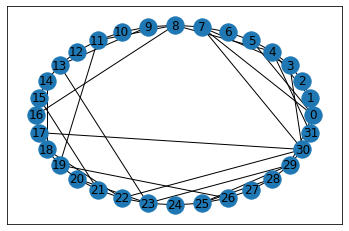

In [10]:
pos = nx.circular_layout(G_sol)
nx.draw_networkx(G_sol,pos=pos,with_labels=True)

In [11]:
#print(sum([x[i,j,:,:].sum()*D[i][j] for (i,j) in complete_node_pair_list0]))

In [15]:
print(calc_cost(G_sol,D))
print(G_sol.edges)

12.285714040000006
[(0, 1), (0, 4), (0, 7), (1, 2), (1, 5), (1, 7), (2, 3), (2, 6), (3, 4), (3, 7), (4, 5), (5, 6), (6, 7)]


In [13]:
def gurobi_optimal(G,D):
    n = len(G.nodes)
    e = opt_mod.addMVar((len(G.nodes), len(G.nodes)), name="e", vtype="B")
    dist = opt_mod.addMVar((len(G.nodes), len(G.nodes)), name="dist", vtype="I", lb=0, ub=GRB.INFINITY)
    x = opt_mod.addMVar((len(G.nodes), len(G.nodes),len(G.nodes), len(G.nodes)), name="x", vtype="B")
    opt_mod.update()
    # Adjacency Matrix (e) Constraints
    opt_mod.addConstrs((e[i,(i+1) % len(G.nodes)] == 1 for i in G.nodes), name="c-ring")
    opt_mod.addConstrs((e[i,i] == 0 for i in G.nodes), name="c-noSelfEdge")
    opt_mod.addConstrs((e[i,j] == e[j,i] for i in G.nodes for j in G.nodes), name="c-undirected")

    maxNumberE =  k+1 #math.log(n,2)-1 + 2
    opt_mod.addConstrs((e[i,:].sum() <= maxNumberE for i in G.nodes), name="c-logE")


        
    # Distance Matrix (dist) Constraints. dist[i][j]:= SP-length between i and j
    opt_mod.addConstrs((x[i,j,:,:].sum()/2==dist[i,j] for i in G.nodes for j in G.nodes), name="c-subpath0")
    opt_mod.addConstrs((dist[i,j] <= dist[i,u] + dist[u,j] for i in G.nodes for j in G.nodes for u in G.nodes),
                      name="c-dist2")




    # Ensuring that x shows a correct path
    opt_mod.addConstrs((x[i,j,u,v] <= e[u,v] for i in G.nodes for j in G.nodes for u in G.nodes for v in G.nodes),
                      name="flow0")
    for i in G.nodes:
        for j in G.nodes:
            if i != j:
                opt_mod.addConstr(x[i,j,i,:].sum() == 1, name="c-flowStart")
                opt_mod.addConstr(x[i,j,:,j].sum() == 1, name="c-flowEnd")
                for v in G.nodes:
                    if v not in [i,j]:
                        opt_mod.addConstr((x[i,j,:,v].sum() - x[i,j,v,:].sum()) == 0, name="blue0")

    #Optimization
    nodesPairListNoDuplication = complete_node_pair_list_noDuplication(G)
    opt_mod.setObjective(sum([dist[i,j]*D[i][j] for (i,j) in nodesPairListNoDuplication]), GRB.MINIMIZE)
    opt_mod.update()
    opt_mod.optimize()

    # Getting result
    G_sol = nx.Graph()
    for i in range(n): 
        G_sol.add_node(i)

    for i in G_sol.nodes:
        for j in range(i+1,len(G_sol.nodes)):
            if e[i,j].X == 1.0:
                G_sol.add_edge(i,j)
    return G_sol

In [14]:
for k in range(2,4):
	G = init_ring(2**k)
	D = init_uniformDemand_matrix_symmetric(G)

	G_sol = gurobi_optimal(G,D)

	solution = calc_cost(G_sol,D)

	f = open("output.txt", "a")
	f.write(str(k) + "," + str(solution)+ "\n")
	f.close()

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 1081852 rows, 1049888 columns and 4010040 nonzeros
Model fingerprint: 0x7725ae3f
Variable types: 1048576 continuous, 1312 integer (272 binary)
Coefficient statistics:
  Matrix range     [5e-01, 1e+00]
  Objective range  [3e-01, 3e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+00]

MIP start from previous solve produced solution with objective 2 (0.86s)
Loaded MIP start from previous solve with objective 2

Presolve removed 130328 rows and 94100 columns (presolve time = 5s) ...
Presolve removed 130344 rows and 94100 columns (presolve time = 10s) ...

Interrupt request received
Presolve removed 130428 rows and 94256 columns
Presolve time: 12.66s
Presolved: 951424 rows, 955632 columns, 3691104 nonzeros
Variable types: 955168 continuous, 464 integer (464 binary)

Explored 0 nodes (0 simplex iterations) in 14.14 se